In [ ]:
# default_exp skymaps
from nbdev.showdoc import show_doc
from utilities.ipynb_docgen import *

%load_ext autoreload
%autoreload 2
! date

Mon Jul  4 10:21:01 PDT 2022


# Sky maps
> Code for making maps of the sky

In [ ]:
#export
import numpy as np
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
from healpy.rotator import Rotator
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from utilities import healpix as hpx

from wtlike.config import *
from wtlike.data_man import DataView, get_week_map
from wtlike.sources import findsource
valid = Config().valid;

This module has plotting code, mainly the `SquareWCS` class for generating square images from all-sky healpix maps.

It deferrs all-sky plots to the `healpix` code in the `utilities` module. There is a TODO to adapt to use `astropy.wcs` instead with its `AIT` projection.

## All sky AIT demo with full data set

Data collection: elapsed time: 39.6s (0.7 min)

<figure style="margin-left: 5%" title="Figure 1">   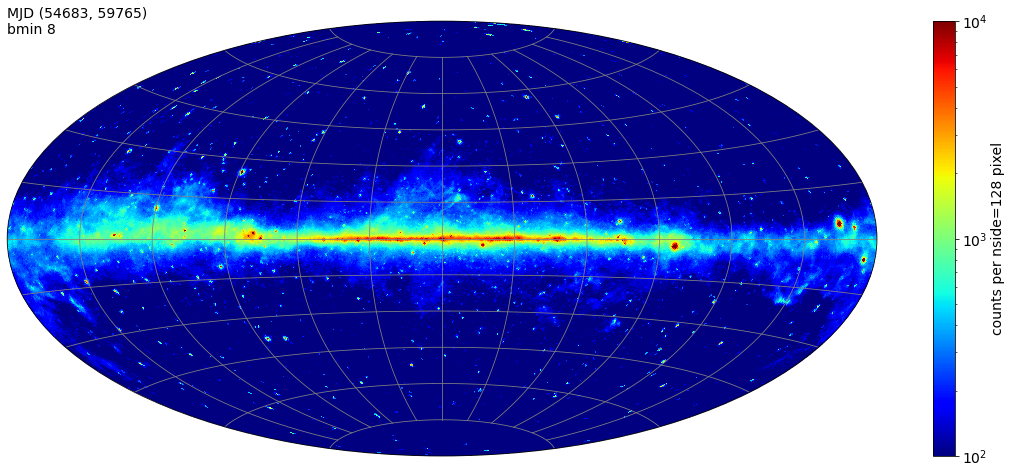 </figure>


In [ ]:
# collapse-hide
skymap = None

@ipynb_doc
def all_sky_demo(bmin=8, nside=128):
    """
    ## All sky AIT demo with full data set
    
    Data collection: {elapsed}
    
    {fig}
    """
    global skymap # save this for subsquent demos
    dvall = DataView()

    with Timer() as elapsed:
        skymap = dvall.count_map(nside=nside, bmin=bmin)

    kw = dict(log=True, tick_labels=False, pixelsize=0.2, figsize=(20,8.),
             cblabel=f'counts per nside={nside} pixel',vmax=1e4, vmin=1e2)
    t = hpx.HPmap(skymap, f'MJD {dvall.time_range}\nbmin {bmin}') 
    fig = t.ait_plot(**kw);
    return locals()

if valid: all_sky_demo()

In [ ]:
# export
def plot_week(week=None, mjd=None, nside=32, **kwargs):
    """
    Make an AIT plot of the given week's photon data
    
    Combine all energies for now
    
    - week -- the week number from 9
    - mjd -- [None] If set, derive the week from it
    - nside [32] -- HEALPix nside to project data before plotting.
    - kwargs -- args for healpix.ait_plot
    
    """
    from utilities import healpix as hpx
    from wtlike.config import mission_week
    if mjd is not None: week=mission_week(mjd)

    pmap = get_week_map(week, nside=nside)

    kw = dict(log=True, tick_labels=False, vmin=5, vmax=1e3,
             cblabel=f'counts per nside={nside} pixel')

    t = hpx.HPmap(pmap, f'week_{week:d}', #\n{utc}', 
                  **kwargs)#f'week_{week:d}\n{utc}', nest=True)
    t.ait_plot(**kw)
    return plt.gcf()

In [ ]:
show_doc(plot_week)

In [ ]:
# collapse-hide
week=79
nside=64

@ipynb_doc
def aitdemo(week, nside):
    """
    ## The Aitoff projection of a HEALPix map
    
    Choose week {week}, with a large 3C 454.3 flare.
    {fig}
    """
    fig=plot_week(week, nside=nside, sigma=0.5)
    return locals()
if valid: aitdemo(79, 64)

In [ ]:
#collapse-hide
pmap = None
@ipynb_doc
def rotatedemo():
    """
    ## Demonstrate a rotation of the HEALPix map
    
    Uses the `Rotation` class of healpy
    {fig}
    """
    global pmap
    pmap = get_week_map(week, nside=nside)

    r = Rotator(coord='GC')
    t = r.rotate_map_pixel(pmap)
    kw = dict(log=True, vmin=1, vmax=100)
    fig = hpx.HPmap(t, f'Equatorial\nprojection').ait_plot(**kw);
    return locals()
if valid: rotatedemo(fignum=1)

In [ ]:
#export

class SquareWCS(WCS):
    """
    Create and use a WCS object
    
    - center : a SkyCoord that will be the center
    - size   : width and height of the display
    - pixsize [0.1] : pixel size
    - frame [None] : The frame is taken from the center SkyCoord, unless specified here --  only accept "galactic" or "fk5"
    - proj ["ZEA"] : projection to use
    """
    
    def __init__(self, center, size, pixsize=0.1, frame=None, proj='ZEA'):
        """
        
        """
        assert isinstance(center, SkyCoord), 'Expect SkyCoord'
        
        frame = frame or center.frame.name
        if frame=='galactic':
            lon, lat = center.galactic.l.deg, center.galactic.b.deg
            lon_name,lat_name = 'GLON','GLAT'
            self.axis_labels='$l$', '$b$'
        elif frame=='fk5':
            lon,lat = center.fk5.ra.deg, center.fk5.dec.deg
            lon_name, lat_name = 'RA--', 'DEC-'
            self.axis_labels = 'RA', 'Dec'
        else:
            raise Exception(f'Expect frame to be "galactic" or "fk5", not {frame}')

        nx=ny=naxis = int(size/pixsize) | 1 # make odd so central pixel has source in middle
        self.center = center
        self.frame=frame
        self.galactic = frame=='galactic'
        super().__init__(
                         dict(
            NAXIS1=nx, CTYPE1=f'{lon_name}-{proj}', CUNIT1='deg', CRPIX1=nx//2+1, CRVAL1=lon, CDELT1=-pixsize,
            NAXIS2=ny, CTYPE2=f'{lat_name}-{proj}', CUNIT2='deg', CRPIX2=ny//2+1, CRVAL2=lat, CDELT2=pixsize, )
              )
        
    def _make_grid(self):
        # get coordinates of every pixel`
        nx, ny = self.array_shape
        pixlists = list(range(1,nx+1)),list(range(1,ny+1))
        cgrid = self.pixel_to_world(*np.meshgrid(*pixlists) ) 
        if not self.galactic:
            cgrid = cgrid.galactic
        lon, lat = (cgrid.l.deg, cgrid.b.deg) 
        return lon, lat
    
    def plot(self, hmap, log=False, cmap='jet', colorbar=True, 
             cblabel='', vmin=None, vmax=None, cb_kw={}, 
             annotator=None, title=None):
        """
        - hmap -- a HEALPix map
    
        """
        
        import healpy as hp
        from matplotlib import colors
        
        wcs = self
        grid = self._make_grid();
        nside = hp.get_nside(hmap)

        # lon, lat = grid.l.deg, grid.b.deg
        ipix = hp.ang2pix(nside, *grid, lonlat=True)

        fig = plt.figure(figsize=(6,6))
        fig.add_subplot(111, projection=self)
        ax = fig.axes[0]
        
        if log:
            norm = colors.LogNorm(vmin=vmin,vmax=vmax)
            vmin=vmax=None
        else:
            norm = None
        ipix = hp.ang2pix(nside, *grid, lonlat=True)
        im = ax.imshow(hmap[ipix], cmap=cmap, origin='lower', norm=norm, vmin=vmin);
        
        nx, ny = wcs.array_shape
        ax.set(xlabel=self.axis_labels[0], xlim=(-0.5, nx-0.5),
               ylabel=self.axis_labels[1], ylim=(-0.5, ny-0.5),
              title= title)
        ax.grid();
        if colorbar:
            ticklabels = cb_kw.pop('ticklabels', None)
            cb_kw.update(label=cblabel,)
            cb = plt.colorbar(im, ax=ax, **cb_kw) 
            if ticklabels is not None: 
                cb.ax.set_yticklabels(ticklabels)
        if annotator is not None:
            annotator(ax, self.frame)
        return fig

In [ ]:
show_doc(SquareWCS)
show_doc(SquareWCS.plot)

In [ ]:
#collapse-hide

@ipynb_doc
def squaremap_demo(name, hpmap, size):
    r"""
    ## Demonstrate SquareWCS
    
    First a ${size}^\circ$ plot in Galactic coordinates, centered on the source "{name}".
    
    The `SquareWCS.plot` function is called with a callback,
    a special `annotate`  function identifies Geminga and the Crab.
    {fig1}
    
    Repeat, using the equatorial "fk5" frame for this one.
    {fig2}
    """

    sc = findsource(name, gal=True)

    swcs = SquareWCS(sc, size=90)

    def annotate(ax, frame):
        
        def source_lonlat(name, gal=True):            
            sky = findsource(name, gal=gal)
            if gal: return sky.galactic.l.deg, sky.galactic.b.deg
            return sky.ra.deg, sky.dec.deg
        
        tf =ax.get_transform(frame) # need the transformation from pixel to world
        for name in ['Geminga', 'Crab pulsar']:
            glb = source_lonlat(name, gal=frame=='galactic')
            ax.scatter(*glb , transform=tf, s=500, edgecolor='black', facecolor='none') 
            ax.text(*glb, '   '+name, color='black', transform=tf);

    fig1 = swcs.plot(hpmap,  log=True, vmin=1, vmax=100, cblabel='counts/pixel',
              cb_kw=dict(ticklabels='0.1 1 10 100'.split(), shrink=0.8),
             annotator = annotate)
    
    swcsc = SquareWCS(sc.fk5, size=90)

    fig2 = swcsc.plot(hpmap, log=True, vmin=1, vmax=100, cblabel='counts/pixel',
          cb_kw=dict(ticklabels='0.1 1 10 100'.split(), shrink=0.8),
         annotator=annotate)
    return locals()
if valid: squaremap_demo('Crab pulsar', hpmap=pmap, size=90, fignum=1)

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 04_skymaps.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10-time_series.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Mon Jul  4 10:24:27 PDT 2022
